# Feature

> A collection of tools to extract features from SMILES, proteins, etc.

## Setup

In [ ]:
#| default_exp feature

In [ ]:
#| export
import pandas as pd, numpy as np
import torch,re,joblib,gc,esm
from tqdm.notebook import tqdm; tqdm.pandas()
from katlas.data import Data
from sklearn.preprocessing import OneHotEncoder

# Rdkit
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw,Descriptors,Descriptors3D, AllChem,rdFingerprintGenerator

# Models
from fairscale.nn.data_parallel import FullyShardedDataParallel as FSDP
from fairscale.nn.wrap import enable_wrap, wrap
from transformers import T5Tokenizer, T5EncoderModel, T5Model

# Dimension Reduction
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from umap.umap_ import UMAP

# Elbow
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


set_config(transform_output="pandas")

## Utils

In [ ]:
#| export
def remove_hi_corr(df: pd.DataFrame, 
                   thr: float=0.98 # threshold
                   ):
    "Remove highly correlated features in a dataframe given a pearson threshold"
    
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > thr)]
    
    # Drop features 
    df = df.drop(to_drop, axis=1)
    
    return df

`remove_hi_corr` is a function to remove highly correlated features based on threshold of Pearson correlation between features.

In [ ]:
# Load data
df = Data.get_aa_rdkit()
df.shape

(25, 106)

In [ ]:
remove_hi_corr(df,thr=0.9).shape

(25, 78)

In [ ]:
#| export
def preprocess(df: pd.DataFrame,
               thr: float=0.98):
    
    "Remove features with no variance, and highly correlated features based on threshold"
    
    col_ori = df.columns
    df = df.loc[:,df.std() != 0].copy()
    df = remove_hi_corr(df, thr)
    dropping_col = set(col_ori) - set(df.columns)
    print(f'removing columns: {dropping_col}')
    return df

This function is similar to `remove_hi_corr`, but can additionaly remove features of zero variance (e.g., 1 across all samples)

In [ ]:
preprocess(df,thr=0.9).shape

removing columns: {'Chi3v', 'SMR_VSA9', 'SMR_VSA1', 'Chi2v', 'fr_SH', 'NumAromaticCarbocycles', 'fr_NH2', 'Chi1v', 'VSA_EState6', 'NumRotatableBonds', 'Chi0n', 'SlogP_VSA5', 'NumAromaticRings', 'fr_Ar_N', 'Chi2n', 'Chi1', 'Chi4n', 'Chi3n', 'VSA_EState10', 'Chi0v', 'Kappa1', 'NumHDonors', 'RingCount', 'NOCount', 'Chi4v', 'Ipc', 'NumHeteroatoms', 'VSA_EState2'}


(25, 78)

In [ ]:
#| export
def standardize(df): 
    "Standardize features from a df"
    return StandardScaler().fit_transform(df.copy())

## Compound features

### RDKit descriptors

In [ ]:
#| export
def get_rdkit(SMILES):
    """
    Extract chemical features from SMILES
    Reference: https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html
    """
    mol = Chem.MolFromSmiles(SMILES)
    return Descriptors.CalcMolDescriptors(mol)

In [ ]:
#| export
def get_rdkit_3d(SMILES):
    """
    Extract 3d features from SMILES
    """
    mol = Chem.MolFromSmiles(SMILES)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)
    return Descriptors3D.CalcMolDescriptors3D(mol)

In [ ]:
#| export
def get_rdkit_all(SMILES):
    "Extract chemical features and 3d features from SMILES"
    feat = get_rdkit(SMILES)
    feat_3d = get_rdkit_3d(SMILES)
    return feat|feat_3d

In [ ]:
#| export
def get_rdkit_df(df,
                 col, # column of SMILES
                 postprocess=True, # remove redundant columns and standardize features for dimension reduction
                 ):
    "Extract rdkit features (including 3d) from SMILES in a df"
    out = df[col].apply(get_rdkit_all).apply(pd.Series)

    if postprocess:
        out = preprocess(out) # remove redundant
        out = standardize(out)
    return out

In [ ]:
aa = Data.get_aa_info()
aa.head()

,Name,SMILES,MW,pKa1,pKb2,pKx3,pl4,H,VSC,P1,P2,SASA,NCISC,phospho
aa,,,,,,,,,,,,,,
A,Alanine,C[C@@H](C(=O)O)N,89.10,2.34,9.69,NaN,6.00,0.62,27.5,8.1,0.046,1.181,0.007187,0
C,Cysteine,C([C@@H](C(=O)O)N)S,121.16,1.96,10.28,8.18,5.07,0.29,44.6,5.5,0.128,1.461,-0.036610,0
D,Aspartic acid,C([C@@H](C(=O)O)N)C(=O)O,133.11,1.88,9.60,3.65,2.77,-0.90,40.0,13.0,0.105,1.587,-0.023820,0
E,Glutamic acid,C(CC(=O)O)[C@@H](C(=O)O)N,147.13,2.19,9.67,4.25,3.22,-0.74,62.0,12.3,0.151,1.862,0.006802,0
F,Phenylalanine,c1ccc(cc1)C[C@@H](C(=O)O)N,165.19,1.83,9.13,NaN,5.48,1.19,115.5,5.2,0.290,2.228,0.037552,0


In [ ]:
aa_rdkit = get_rdkit_df(aa, 'SMILES')
aa_rdkit.head()

removing columns: {'fr_para_hydroxylation', 'MinAbsPartialCharge', 'SlogP_VSA9', 'NumSpiroAtoms', 'fr_sulfone', 'PEOE_VSA5', 'fr_Ndealkylation1', 'fr_halogen', 'MolMR', 'fr_nitro_arom', 'VSA_EState1', 'fr_piperdine', 'fr_lactam', 'fr_imide', 'PMI3', 'fr_methoxy', 'Chi0', 'fr_alkyl_carbamate', 'Asphericity', 'fr_bicyclic', 'PEOE_VSA13', 'fr_sulfonamd', 'Chi1n', 'fr_urea', 'fr_aryl_methyl', 'NumBridgeheadAtoms', 'fr_hdrzine', 'fr_nitro', 'fr_phos_acid', 'fr_pyridine', 'fr_nitro_arom_nonortho', 'fr_amide', 'Eccentricity', 'fr_azo', 'fr_isocyan', 'HeavyAtomCount', 'fr_oxazole', 'SMR_VSA2', 'NumRadicalElectrons', 'fr_epoxide', 'fr_Nhpyrrole', 'fr_term_acetylene', 'fr_hdrzone', 'BCUT2D_MRHI', 'fr_aldehyde', 'fr_Ar_NH', 'fr_ketone_Topliss', 'fr_allylic_oxid', 'NumAmideBonds', 'NumAliphaticCarbocycles', 'NumSaturatedCarbocycles', 'fr_thiazole', 'fr_amidine', 'fr_phenol', 'fr_Ar_OH', 'fr_nitrile', 'fr_phos_ester', 'fr_nitroso', 'fr_benzodiazepine', 'NumAliphaticRings', 'fr_azide', 'fr_COO2', 'f

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MinPartialCharge,MaxAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,...,fr_sulfide,fr_unbrch_alkane,PMI1,PMI2,NPR1,NPR2,RadiusOfGyration,InertialShapeFactor,SpherocityIndex,PBF
aa,,,,,,,,,,,,,,,,,,,,,
A,-1.653421,1.218945,0.407753,-0.383393,-0.070345,-1.523488,0.218275,-0.295105,1.732180,0.163309,...,-0.204124,-0.369274,-1.294800,-1.086763,1.710287,1.057430,-1.514798,1.952520,0.622167,-1.068611
C,-1.058215,-0.588000,0.372307,-0.641865,-0.138884,-0.727067,0.223839,-0.298132,1.732180,1.481227,...,-0.204124,-0.369274,-0.445607,-0.885625,1.398986,-2.080741,-0.970023,-0.247854,0.617683,-0.493157
D,-0.764466,0.554854,0.126078,-0.376981,-0.390192,-0.430473,0.020085,-0.187297,-0.934412,-1.234483,...,-0.204124,-0.369274,-0.724059,-0.459223,-0.441549,0.454216,-0.332705,0.426131,0.316338,0.080717
E,-0.283221,-1.143984,0.235448,-0.051582,-0.406185,-0.082096,0.010166,-0.181902,-1.147739,-1.178571,...,-0.204124,-0.369274,-0.504211,-0.096004,-0.699329,1.605206,0.070614,0.283217,-0.128709,-0.453659
F,0.972596,0.063427,0.410788,1.908107,-0.430173,0.366494,0.221306,-0.296754,-1.067741,-0.675366,...,-0.204124,-0.369274,-0.220806,0.390422,-1.137341,0.320498,0.643196,-0.162855,-1.214938,-0.971254


### Morgan fingerprint

In [ ]:
#| export
def get_morgan(df: pd.DataFrame, # a dataframe that contains smiles
               col: str = "SMILES", # colname of smile
               radius=3
              ):
    "Get 2048 morgan fingerprint (binary feature) from smiles in a dataframe"
    mols = [Chem.MolFromSmiles(smi) for smi in df[col]]

    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=2048)
    morgan_fps = [mfpgen.GetFingerprint(mol) for mol in mols]
    
    fp_df = pd.DataFrame(np.array(morgan_fps), index=df.index)
    fp_df.columns = "morgan_" + fp_df.columns.astype(str)
    return fp_df

In [ ]:
aa_morgan = get_morgan(aa, 'SMILES')
aa_morgan.head()

,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,morgan_6,morgan_7,morgan_8,morgan_9,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
aa,,,,,,,,,,,,,,,,,,,,,
A,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
aa_morgan = get_morgan(aa, 'SMILES')
aa_morgan.head()

,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,morgan_6,morgan_7,morgan_8,morgan_9,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
aa,,,,,,,,,,,,,,,,,,,,,
A,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Protein sequence

### Onehot

In [ ]:
#| export
def onehot_encode(sequences, transform_colname=True, n=20):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_array = encoder.fit_transform([list(seq) for seq in sequences])
    colnames = [x[1:] for x in encoder.get_feature_names_out()]
    if transform_colname:
        colnames = [f"{int(item.split('_', 1)[0]) - 20}{item.split('_', 1)[1]}" for item in colnames]
    encoded_df = pd.DataFrame(encoded_array)
    encoded_df.columns=colnames
    return encoded_df

In [ ]:
df=Data.get_combine_site_psp_ochoa()

In [ ]:
onehot = onehot_encode(df['site_seq'].head(1000))
onehot

,-20A,-20C,-20D,-20E,-20F,-20G,-20H,-20I,-20K,-20L,...,-6N,-6P,-6Q,-6R,-6S,-6T,-6V,-6W,-6Y,-6_
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Elbow method

In [ ]:
#| export
def get_clusters_elbow(encoded_data,max_cluster=400, interval=50):

    wcss = []
    for i in range(1, max_cluster,interval):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(encoded_data)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow graph
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, max_cluster,interval), wcss)
    plt.title(f'Elbow Method (n={len(encoded_data)})')
    plt.xlabel('# Clusters')
    plt.ylabel('WCSS')

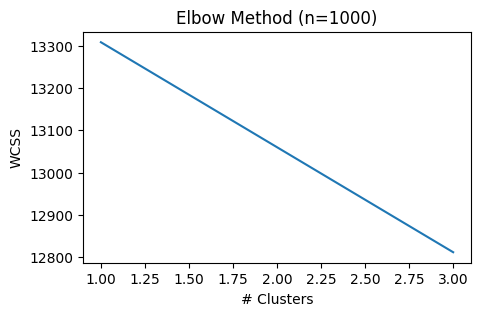

In [ ]:
get_clusters_elbow(onehot,5,2)

### ESM2

In [ ]:
#| export
def get_esm(df:pd.DataFrame, # a dataframe that contains amino acid sequence
            col: str = 'sequence', # colname of amino acid sequence
            model_name: str = "esm2_t33_650M_UR50D", # Name of the ESM model to use for the embeddings.
            ):
    
    "Extract esmfold2 embeddings from protein sequence in a dataframe"
    
    # Initialize distributed world with world_size 1
    if not torch.distributed.is_initialized():
        url = "tcp://localhost:23456"
        torch.distributed.init_process_group(backend="nccl", init_method=url, world_size=1, rank=0)
    
    #get number of repr layers
    match = re.search(r'_t(\d+)_', model_name)
    number = int(match.group(1))
    print(f"repr_layers number for model {model_name} is {number}.")
    print("You can also choose other esm2 models:",
          "\nesm2_t48_15B_UR50D\nesm2_t36_3B_UR50D\nesm2_t33_650M_UR50D\nesm2_t30_150M_UR50D\nesm2_t12_35M_UR50D\nesm2_t6_8M_UR50D\n")

    # Download model data from the hub
    model_data, regression_data = esm.pretrained._download_model_and_regression_data(model_name)

    # Initialize the model with FSDP wrapper
    fsdp_params = dict(
        mixed_precision=True,
        flatten_parameters=True,
        state_dict_device=torch.device("cpu"),  # reduce GPU mem usage
        cpu_offload=True,  # enable cpu offloading
    )

    with enable_wrap(wrapper_cls=FSDP, **fsdp_params):
        model, vocab = esm.pretrained.load_model_and_alphabet_core(
            model_name, model_data, regression_data
        )
        batch_converter = vocab.get_batch_converter()
        model.eval()

        # Wrap each layer in FSDP separately
        for name, child in model.named_children():
            if name == "layers":
                for layer_name, layer in child.named_children():
                    wrapped_layer = wrap(layer)
                    setattr(child, layer_name, wrapped_layer)
        model = wrap(model)

        # Define the feature extraction function
        def esm_embeddings(r, colname=col):
            data = [('protein', r[colname])]
            labels, strs, tokens = batch_converter(data)
            with torch.no_grad():
                results = model(tokens.cuda(), repr_layers=[number], return_contacts=False)
            rpr = results["representations"][number].squeeze()
            rpr = rpr[1 : len(r[colname]) + 1].mean(0).detach().cpu().numpy()

            del results, labels, strs, tokens, data #especially need to delete those on cuda: tokens, results
            gc.collect()

            return rpr
        
        # Apply the feature extraction function to each row in the DataFrame
        series = df.progress_apply(esm_embeddings, axis=1)
        df_feature = pd.DataFrame(series.tolist(), index=df.index)
        df_feature.columns = 'esm_' + df_feature.columns.astype(str)

        return df_feature

[ESM2 model](https://github.com/facebookresearch/esm) is trained on UniRef sequence. The default model in the function is esm2_t33_650M_UR50D, which is trained  on UniRef50.

Uncheck below to use:

In [ ]:
# # Examples
# df = Data.get_kinase_info().set_index('kinase')
# sample = df[:5]
# esmfeature = get_esm(sample,'sequence')
# esmfeature.head()

### ProtT5

In [ ]:
#| export
def get_t5(df: pd.DataFrame, 
           col: str = 'sequence'
           ):
    "Extract ProtT5-XL-uniref50 embeddings from protein sequence in a dataframe"
    
    # Reference: https://github.com/agemagician/ProtTrans/tree/master/Embedding/PyTorch/Advanced
    # Load the tokenizer
    tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

    # Load the model
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to('cuda')

    # Set the model precision based on the device
    model.half()
    
    def T5_embeddings(sequence):
        seq_len = len(sequence)
        # Prepare the protein sequences as a list
        sequence = [" ".join(list(re.sub(r"[UZOB]", "X", sequence)))]

        # Tokenize sequences and pad up to the longest sequence in the batch
        ids = tokenizer.batch_encode_plus(sequence, add_special_tokens=True, padding="longest")
        input_ids = torch.tensor(ids['input_ids']).to('cuda')
        attention_mask = torch.tensor(ids['attention_mask']).to('cuda')

        # Generate embeddings
        with torch.no_grad():
            embedding_rpr = model(input_ids=input_ids, attention_mask=attention_mask)

        emb_mean = embedding_rpr.last_hidden_state[0][:seq_len].detach().cpu().numpy().mean(axis=0)

        return emb_mean

    series = df[col].progress_apply(T5_embeddings)
        

    T5_feature = pd.DataFrame(series.tolist(),index=df.index)
    T5_feature.columns = 'T5_' + T5_feature.columns.astype(str)
    
    return T5_feature

[XL-uniref50 model](https://huggingface.co/Rostlab/prot_t5_xl_uniref50) is a t5-3b model trained on Uniref50 Dataset.

Uncheck below to use:

In [ ]:
# t5feature = get_t5(sample,'sequence')
# t5feature.head()

In [ ]:
#| export
def get_t5_bfd(df:pd.DataFrame, 
               col: str = 'sequence'
               ):
    
    "Extract ProtT5-XL-BFD embeddings from protein sequence in a dataframe"
    # Reference: https://github.com/agemagician/ProtTrans/tree/master/Embedding/PyTorch/Advanced
    # Load the tokenizer
    tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_bfd', do_lower_case=False)

    model = T5Model.from_pretrained("Rostlab/prot_t5_xl_bfd").to('cuda')

    model.eval()
    
    def T5_embeddings_bfd(sequence, device = 'cuda'):

        seq_len = len(sequence)

        # Prepare the protein sequences as a list
        sequence = [" ".join(list(re.sub(r"[UZOB]", "X", sequence)))]

        # Tokenize sequences and pad up to the longest sequence in the batch
        ids = tokenizer.batch_encode_plus(sequence, add_special_tokens=True, padding="longest")
        input_ids = torch.tensor(ids['input_ids']).to(device)
        attention_mask = torch.tensor(ids['attention_mask']).to(device)

        # Generate embeddings
        with torch.no_grad():
            embedding_rpr = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids = input_ids)

        emb_mean = embedding_rpr.last_hidden_state[0][:seq_len].detach().cpu().numpy().mean(axis=0)

        return emb_mean

    series = df[col].progress_apply(T5_embeddings_bfd)
        

    T5_feature = pd.DataFrame(series.tolist(),index=df.index)
    T5_feature.columns = 'T5bfd_' + T5_feature.columns.astype(str)
    
    return T5_feature

[XL-BFD model](https://huggingface.co/Rostlab/prot_t5_xl_bfd) is a t5-3b model trained on Big Fantastic Database(BFD).

Uncheck below to use:

In [ ]:
# t5bfd = get_t5_bfd(sample,'sequence')
# t5bfd.head()

## Dimensionality reduction

In [ ]:
#| export
def reduce_feature(df: pd.DataFrame, 
                   method: str='pca', # dimensionality reduction method, accept both capital and lower case
                   complexity: int=20, # None for PCA; perfplexity for TSNE, recommend: 30; n_neigbors for UMAP, recommend: 15
                   n: int=2, # n_components
                   load: str=None, # load a previous model, e.g. model.pkl
                   save: str=None, # pkl file to be saved, e.g. pca_model.pkl
                   seed: int=123, # seed for random_state
                   **kwargs, # arguments from PCA, TSNE, or UMAP depends on which method to use
                  ):
    
    "Reduce the dimensionality given a dataframe of values"
    
    method = method.lower()
    assert method in ['pca','tsne','umap'], "Please choose a method among PCA, TSNE, and UMAP"
    
    if load is not None:
        reducer = joblib.load(load)
    else:
        if method == 'pca':
            reducer = PCA(n_components=n, random_state=seed,**kwargs)
        elif method == 'tsne':
            reducer = TSNE(n_components=n,
                           random_state=seed, 
                           perplexity = complexity, # default from official is 30 
                          **kwargs)
        elif method == 'umap':
            reducer = UMAP(n_components=n, 
                           random_state=seed, 
                           n_neighbors=complexity, # default from official is 15, try 15-200
                          **kwargs)
        else:
            raise ValueError('Invalid method specified')

    proj = reducer.fit_transform(df)
    embedding_df = pd.DataFrame(proj).set_index(df.index)
    embedding_df.columns = [f"{method.upper()}{i}" for i in range(1, n + 1)]

    if save is not None:
        path = Path(save)
        path.parent.mkdir(exist_ok=True)
        
        joblib.dump(reducer, save)

    return embedding_df

A very common way to reduce feature number is to use dimensionality reduction method. `reduce_feature` is a dimensionality reduction function that can apply three dimensionality reduction methods: PCA, UMAP, TSNE. The later two is non-linear transformation, and PCA is linear transformation. Therefore, for plotting purpose, it is good to use UMAP/TSNE, by setting n (n_components) to 2 for 2d plot; for featuring purpose, it is good to use PCA, and set n to values to a rational values, like 64, 128 etc. 

In [ ]:
# Load data
df = Data.get_aa_rdkit()

# Use PCA to reduce dimension; reduce the number of features to 20
reduce_feature(df,'pca',n=20).head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20
aa,,,,,,,,,,,,,,,,,,,,
A,-463.014948,-79.180061,-8.957621,-13.455810,1.334975,0.996915,-6.228205,-2.573987,0.637178,1.904173,-1.165818,5.803809,-3.519867,1.620306,-3.686674,-1.070729,-1.044587,-2.245493,-0.023173,2.143434
C,-446.251885,-52.851228,1.200874,0.469406,-16.721236,12.310611,5.623647,17.543569,6.290376,-4.818617,0.871101,-1.274344,3.983329,-6.019231,-5.866159,-0.339787,-3.342606,0.934348,-0.335121,-0.045040
D,-407.721016,9.532878,10.375789,-21.871983,-3.757091,-2.804468,3.684495,-8.257556,0.885011,4.454468,4.085862,3.059634,3.463971,2.626308,1.260286,-3.054156,-1.823627,4.300302,-2.407938,1.076088
E,-355.786380,21.077202,11.870110,-10.861780,4.869825,-3.906521,-2.281413,-2.893303,8.997722,3.828554,2.004998,-1.002484,9.471326,-1.945113,3.684237,2.119809,0.362597,-1.166347,-3.604024,-0.752169
F,69.598210,74.375112,-68.407808,2.572185,6.659703,16.787547,10.585299,-1.588954,-10.532959,-2.643261,-7.012191,4.522682,4.779671,0.908865,-0.218389,1.152286,0.560021,1.736196,0.152801,-0.567469


## End

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()